In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
GROQ_API_KEY = os.getenv('GROQ_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
SERPER_API_KEY= os.getenv('SERPER_API_KEY')

os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY
os.environ['GROQ_API_KEY'] = GROQ_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['LANGSMITH_API_KEY'] = LANGSMITH_API_KEY
os.environ['SERPER_API_KEY'] = SERPER_API_KEY
LANGSMITH_TRACING="true"
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_PROJECT="langgraph-prerequist"

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [47]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()
llm.invoke('hi')

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BKJ7FWyz6ggBikTViaoKe7DV0L8T0', 'finish_reason': 'stop', 'logprobs': None}, id='run-df08f142-0305-4a84-93f1-4ed7d5dca043-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [10]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    
    collection_name="rag-chroma",
    embedding=embeddings,
    persist_directory='chromadb'
)
retriever = vectorstore.as_retriever()

In [11]:
retriever.invoke('what is agent')

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

In [ ]:
from langchain.tools.retriever import create_retriever_tool
from langchain_community.tools import TavilySearchResults

search = TavilySearchResults(k=3)

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)



In [77]:
search.invoke('What is the capital of india?')

[{'title': 'What is the capital of India? States and union territories explained.',
  'url': 'https://www.usatoday.com/story/news/world/2023/05/24/what-is-the-capital-of-india/70195720007/',
  'content': 'The capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River. Calcutta (now Kolkata, the',
  'score': 0.926683},
 {'title': 'Capital City of India - CountryReports.org',
  'url': 'https://www.countryreports.org/country/India/capital-city.htm',
  'content': 'India\nOverview\nPeople\nGovernment - Politics\n- Government - Politics\n- Capital City\n- National Defense\nGeography\nEnvironment & Climate\nEconomy\nNews - Weather\nHistory\nNational Symbols\nPhotos\nVideos\nTravel and Tourism\nEspanol- traducción automática\nLink-to-CountryReports\nSources\n\xa0\nUnited States Edition\nVideo Library\nCountryReports\nCountries\nActivities\nSign In\nWhat is the Capital of India?\nCapital City    New Delhi\nCapital location    28 36 N, 77 12 E

In [87]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [88]:
state = AgentState()
state = {'messages':['hi, how are you?']}

In [89]:
state

{'messages': ['hi, how are you?']}

In [90]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
# from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

from langgraph.prebuilt import tools_condition

In [ ]:

### Edges


def grade_documents(state) -> Literal["generate", "rewrite",  "web_search"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM

    # LLM with tool and validation
    llm_with_tool = llm.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        if use_tavily:  # You can gate this with a config or fallback toggle
            return "web_search"
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = llm.bind_tools(tools1)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
            Look at the input and try to reason about the underlying semantic intent / meaning. \n 
            Here is the initial question:
            \n ------- \n
            {question} 
            \n ------- \n
            Formulate an improved question: """,
        )
    ]

    # Grader
    response = llm.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

def web_search(state):
    """
    Use Tavily to fetch relevant info if retrieval fails or docs aren't good enough.
    """
    print("---TAVILY SEARCH---")
    question = state["messages"][0].content
    results = search.invoke(question)
    return {"messages": [results]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [98]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
# tool_node2 = ToolNode([search])
# workflow.add_node('search_tool',tool_node2 )
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")


# Compile
graph = workflow.compile()


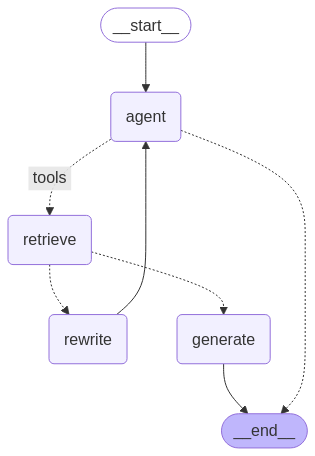

In [99]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(e)

In [71]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about the types of agent memory?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NxqIDtL6mRTC8xLEjmBfAxN8', 'function': {'arguments': '{"query":"types of agent memory"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 149, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BKJYJQMzO7NbVCVXWgw5YEw0Q2pmv', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-57e00af4-3557-4c9f-b3f0-e40cf277446b-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'types of agent memory'}, 'id': 'call_NxqIDtL6mRTC8xLEjmBfAxN8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 

In [72]:
result = graph.invoke(inputs)
result

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What does Lilian Weng say about the types of agent memory?', additional_kwargs={}, response_metadata={}, id='c0bbac2e-47eb-4823-a051-25605116a962'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_u0JQyypxfO7Op4EaQJYj35sr', 'function': {'arguments': '{"query":"types of agent memory"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 149, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BKJYNLDm90PioK2ZrOYxsUiyb5OdP', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b5981d17-b8fd-482a-b81d-2764e7244b83-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 

In [73]:
result['messages'][-1].content

"Lilian Weng discusses the types of agent memory, which includes a long-term memory module called memory stream that records agents' experiences in natural language. The design of generative agents combines memory, planning, and reflection mechanisms to enable agents to behave based on past experiences and interact with other agents efficiently. The retrieval model helps the agent's behavior by surfacing context based on relevance, recency, and importance."

In [84]:
result = graph.invoke({'messages':['What is the capital of india?']})
result

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='What is the capital of india?', additional_kwargs={}, response_metadata={}, id='74a2b68b-9848-40a2-aca5-1f8dc71e7e0e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jrHmnhRRLDyUjOCP7AUCErrl', 'function': {'arguments': '{"query":"capital of India"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 142, 'total_tokens': 163, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BKJfbHDAR5PgnFPMwT1GOsx5QbN53', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f1bb150-0e0b-4003-a4cb-9a2dcfffafde-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'capital of India'},

In [85]:
result['messages'][-1].content

'"What is the capital of India?"'

In [83]:
for output in graph.stream({'messages':['What is the capital of india?']}):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_auX4tu3EKEIxGecVJTyAJ1hj', 'function': {'arguments': '{"query":"capital of India"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 142, 'total_tokens': 163, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BKJf6smGWSTKLyTkhu1Lxi4ycUM2K', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4f445fa8-00f8-4fd5-aada-9037bb0fd3a5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'capital of India'}, 'id': 'call_auX4tu3EKEIxGecVJTyAJ1hj', 'type': 'tool_call'}], usage_metadata={'input_token

In [60]:
llm.invoke('what is the capital of india?')

AIMessage(content='The capital of India is New Delhi.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 14, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BKJPQrL1DgVx1PzPktpX8baRBqICx', 'finish_reason': 'stop', 'logprobs': None}, id='run-d539c70a-7516-4d6b-ad94-72d2ad6394c7-0', usage_metadata={'input_tokens': 14, 'output_tokens': 9, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})